Find Lane Line In One Image
===

# 1. Image Calibration

In [1]:
from os.path import join as opj
import glob

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from src.image_calibration import calibration, undistort
from src.utils import grayscale, rgb


CALIBRATION_IMAGE_FOLDER = 'camera_cal'
TEST_IMAGE_PATH = 'test_images/straight_lines1.jpg'


### Calculate Distortion Matrix and Coefficients

In [2]:
image_filenames = glob.glob(opj(CALIBRATION_IMAGE_FOLDER, '*.jpg'))
ret, mtx, dist = calibration(image_filenames, (9, 6))

test_image = cv2.imread(TEST_IMAGE_PATH)
undistorted_image = undistort(test_image, mtx, dist)

did not find any corners in camera_cal/calibration4.jpg
did not find any corners in camera_cal/calibration5.jpg
did not find any corners in camera_cal/calibration1.jpg


### Test Undistortion on sample image

Text(0.5,1,'Undistorted Image')

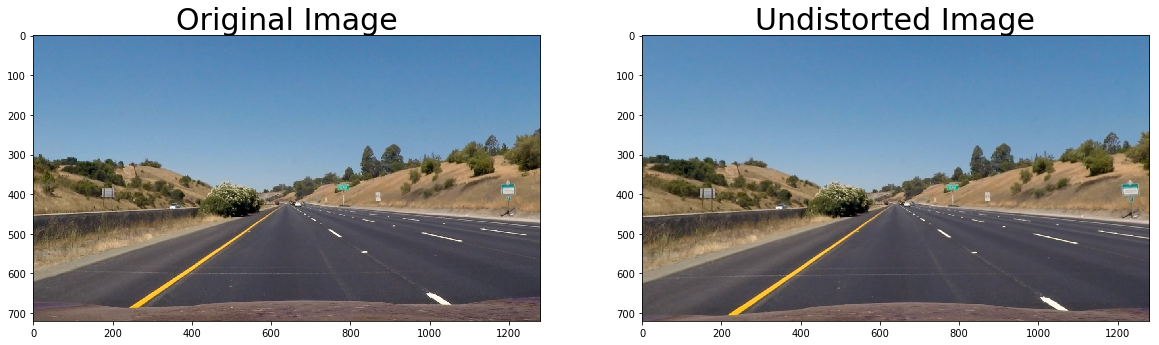

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(rgb(test_image))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(rgb(undistorted_image))
ax2.set_title('Undistorted Image', fontsize=30)

# 2. Create thresholded binary image using color transforms, gradients, etc.

#### 2.1 Thresholding Method

Text(0.5,1,'thresh_combined')

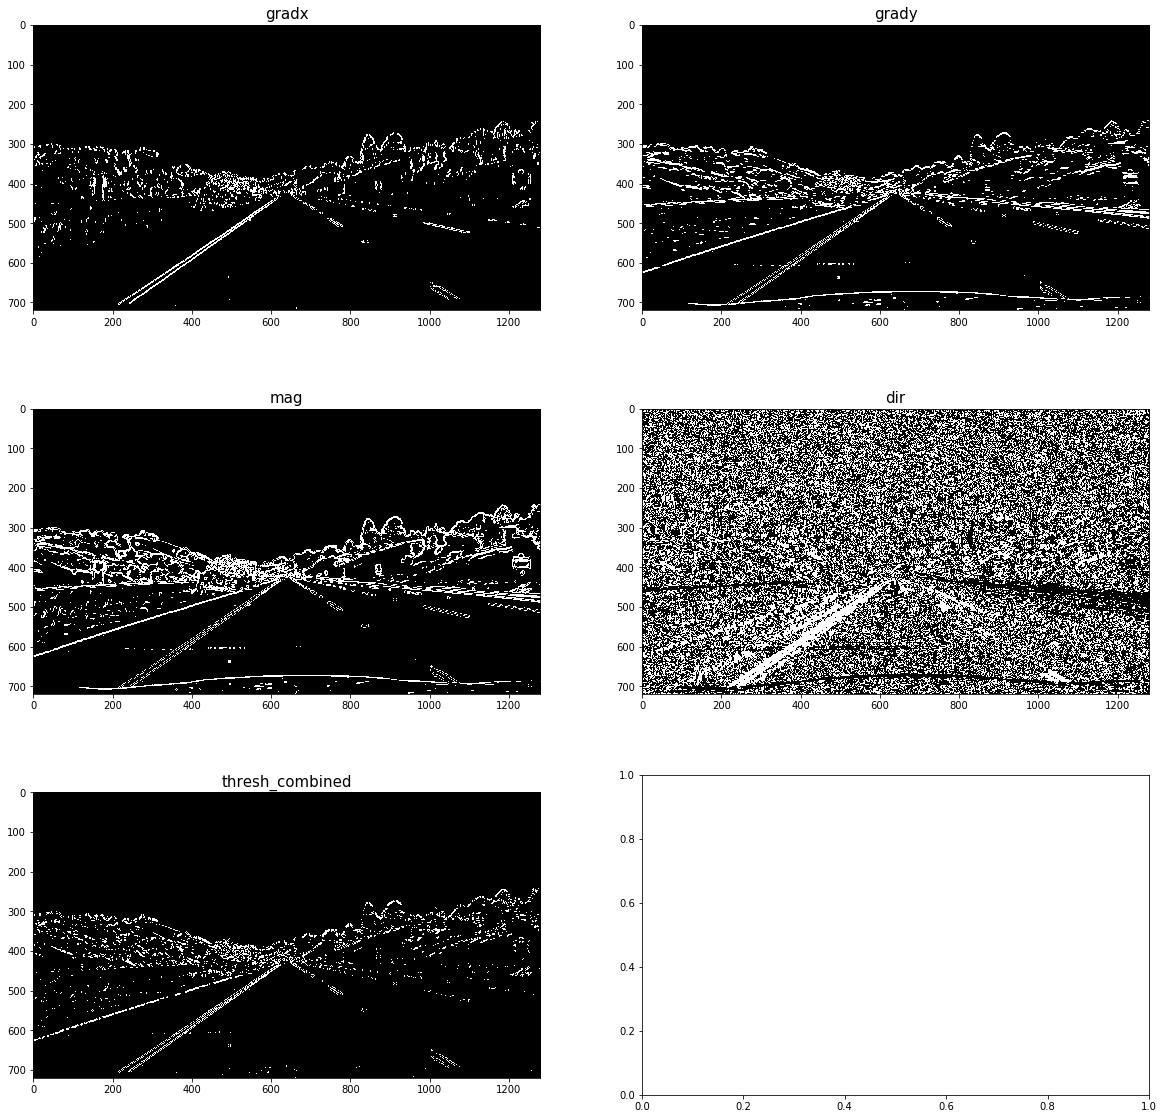

In [18]:
def abs_sobel_thresh(img, orient='x', kernel_size=3, thresh=(0, 255)):
    direc = (1, 0) if orient == 'x' else (0, 1)
    sobel = cv2.Sobel(img, cv2.CV_64F, *direc, ksize=kernel_size)
    abs_img = np.abs(sobel)
    normalized_img = np.uint8(255 * abs_img / np.max(abs_img))
    thresholded_img = np.zeros_like(normalized_img)
    thresholded_img[(normalized_img >= thresh[0]) & (normalized_img <= thresh[1])] = 1
    return thresholded_img

def mag_thresh(img, kernel_size=3, thresh=(30, 100)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)
    normalized_img = np.uint8(255 * magnitude / np.max(magnitude))
    thresholded_img = np.zeros_like(normalized_img)
    thresholded_img[(normalized_img >= thresh[0]) & (normalized_img <= thresh[1])] = 1
    return thresholded_img

def dir_threshold(img, kernel_size=3, thresh=(0, np.pi/2)):
    abs_sobelx = np.abs(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    abs_sobely = np.abs(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    grad_img = np.arctan2(abs_sobely, abs_sobelx)
    thresholded_img = np.zeros_like(grad_img)
    thresholded_img[(grad_img >= thresh[0]) & (grad_img <= thresh[1])] = 1
    return thresholded_img

# undistort and gray image
undistorted_gray_img = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undistorted_gray_img, orient='x', kernel_size=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(undistorted_gray_img, orient='y', kernel_size=ksize, thresh=(30, 100))
mag_binary = mag_thresh(undistorted_gray_img, kernel_size=ksize, thresh=(30, 100))
dir_binary = dir_threshold(undistorted_gray_img, kernel_size=15, thresh=(0.7, 1.3))

thresh_combined = np.zeros_like(dir_binary)
thresh_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(20, 20))
ax1.imshow(gradx, cmap='gray')
ax1.set_title('gradx', fontsize=15)
ax2.imshow(grady, cmap='gray')
ax2.set_title('grady', fontsize=15)
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('mag', fontsize=15)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('dir', fontsize=15)
ax5.imshow(thresh_combined, cmap='gray')
ax5.set_title('thresh_combined', fontsize=15)
# plt.imshow(combined)

#### Color Space Transformation

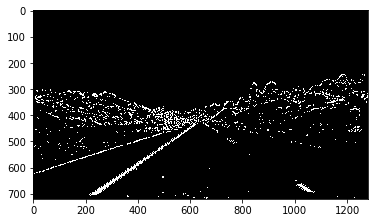

In [19]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
# color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(thresh_combined)
combined_binary[(s_binary == 1) | (thresh_combined == 1)] = 1

# Plotting thresholded images
plt.imshow(combined_binary, cmap='gray')

In [ ]:
sobelx = cv2.Sobel(undistorted_gray_img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(undistorted_gray_img, cv2.CV_64F, 0, 1, ksize=3)
print(sobelx.min(), sobelx.max())


In [ ]:
sobelx.shape
# plt.imshow(sobelx)